<a href="https://colab.research.google.com/github/andersthequeen/cis545/blob/master/538_Presidential_Election_Confidence_Interval_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#538 Presidential Election Confidence Interval Review

## Author: Anders Zhou

The purpose of this short piece of code is to scrape from NYT's election data, discern the voting percentages of the incumbent (Trump) and challenger (Biden), and **evaluate how 538's projected confidence intervals lined up with the true results of the 2020 Presidential Election.**


##Scraping from New York Times
https://www.nytimes.com/interactive/2020/11/03/us/elections/results-virginia.html?action=click&module=ELEX_results&pgtype=Interactive&region=FooterNavigation
https://www.nytimes.com/interactive/2020/11/03/us/elections/results-california-president.html


In [26]:
%%capture
!pip3 install requests_html

import re
import urllib
import requests
import pandas as pd
from lxml import html
from lxml import etree
from io import StringIO, BytesIO
from requests_html import HTML, HTMLSession
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [180]:
session = HTMLSession()
election_urls = []
scrape_df = pd.DataFrame(columns = ['state', 'd_real', 'r_real'])
url = "https://www.nytimes.com/interactive/2020/11/03/us/elections/results-president.html?action=click&pgtype=Article&state=default&module=styln-elections-2020&region=TOP_BANNER&context=election_recirc"
r = session.get(url)
soup = BeautifulSoup(r.text, 'html.parser')

for a in soup.find_all('a', {'class': 'e-text-color e-democrat'}):
  election_urls.append(a['href'])
for b in soup.find_all('a', {'class': 'e-text-color e-republican'}):
  election_urls.append(b['href'])
election_urls = list(dict.fromkeys(election_urls))

for url in election_urls:
  r = session.get(url)
  soup = BeautifulSoup(r.text, 'html.parser')
  party = soup.findAll("span", attrs = {"class": "e-party-display"})
  percent = soup.findAll("span", attrs = {"class": "e-percent-val"})

  if(str(party[0].contents[0]) == "Democrat"):
    d_real = float(percent[0].contents[0])
    r_real = float(percent[1].contents[0])
  else:
    d_real = float(percent[1].contents[0])
    r_real = float(percent[0].contents[0])
  
  state = str(url).split('results-')[1].split('-president')[0]

  scrape_df = scrape_df.append({'state' : state, 'd_real' : d_real, 'r_real' : r_real}, ignore_index = True)

## Using open-source data from 538

In [150]:
from google.colab import files
uploaded = files.upload()

Saving presidential_state_toplines_2020.csv to presidential_state_toplines_2020.csv


In [213]:
import io
df_538 = pd.read_csv(io.BytesIO(uploaded['presidential_state_toplines_2020.csv']))
df_538 = df_538[df_538['modeldate'].str.contains('11/3/20')]
df_538 = df_538[['state','voteshare_inc_hi', 'voteshare_chal_hi', 
                 'voteshare_inc_lo', 'voteshare_chal_lo', 
                 'voteshare_inc', 'voteshare_chal']]
df_538['state'] = df_538['state'].apply(lambda x: x.replace(' ', '-').lower())
df_538.head(5)

,state,voteshare_inc_hi,voteshare_chal_hi,voteshare_inc_lo,voteshare_chal_lo,voteshare_inc,voteshare_chal
0,wyoming,70.99022,36.18585,60.52768,25.93248,65.77760,31.04658
1,wisconsin,48.68993,56.99251,42.07389,50.39740,45.37802,53.68898
2,west-virginia,70.77528,40.13931,58.12693,27.47620,64.48556,33.77089
3,washington,42.22951,65.99652,31.79709,55.51974,37.00352,60.76666
4,virginia,46.40628,58.82807,40.23785,52.66484,43.28946,55.77469


In [249]:
master_df = df_538.merge(scrape_df, how = 'inner', on = 'state')

def subtract(proj, real):
  return proj - real

master_df['inc_dif'] = master_df.apply(lambda x: round(x['r_real'] - x['voteshare_inc'], 2), axis = 1)
master_df['chal_dif'] = master_df.apply(lambda x: round(x['d_real'] - x['voteshare_chal'], 2), axis = 1)
master_df.head(5)

,state,voteshare_inc_hi,voteshare_chal_hi,voteshare_inc_lo,voteshare_chal_lo,voteshare_inc,voteshare_chal,d_real,r_real,inc_dif,chal_dif
0,wyoming,70.99022,36.18585,60.52768,25.93248,65.77760,31.04658,26.60,70.00,4.22,-4.45
1,wisconsin,48.68993,56.99251,42.07389,50.39740,45.37802,53.68898,49.45,48.83,3.45,-4.24
2,west-virginia,70.77528,40.13931,58.12693,27.47620,64.48556,33.77089,29.60,68.60,4.11,-4.17
3,washington,42.22951,65.99652,31.79709,55.51974,37.00352,60.76666,58.80,38.70,1.70,-1.97
4,virginia,46.40628,58.82807,40.23785,52.66484,43.28946,55.77469,54.10,44.30,1.01,-1.67


In [233]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Setup a plot such that only the bottom spine is shown
def setup(ax):
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(which='major', width=1.00)
    ax.tick_params(which='major', length=5)
    # ax.tick_params(which='minor', width=0.75)
    # ax.tick_params(which='minor', length=2.5)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.patch.set_alpha(0.0)

def color(num):
  if num < 0:
    return 'red'
  else:
    return 'black'

## Summary

In each of the 50 number-line plots presented below, the shaded region and vertical bar represent 538's prediction of each candidates' share of the votes in each state. The dots represent each candidates' actual voteshare.

**Donald Trump outperformed 538's voteshare prediction in 47 states out of 50**, while **Joe Biden underperformed 538's voteshare prediction in 48 states**. Moreover, Donald Trump's voteshare tended to cling around the upper-end of 538's confidence interval, sometimes overshooting their confidence interval. Joe Biden had the opposite effect.

538 underpredicted DT's performance 47 times out of 50. In a "normal" world where there we would expect 538 to underpredict and overpredict DT's performance equally — akin to a coin flip —
we would expect 538 to underpredict DT's performance 25 times out of 50. A binomial distribution tells us that the probability of 538 underpredicting DT's performance 47 times out of 50 would be about 1.854 E-11, which is infinitesimally small. However, we know that political predictioins across states shouldn't be considered from a coin-flip perspective.

> *****

Here are some *suggested* insights on the landscape of political predictions:

*Credit to Jason Leung*

1.  NYT, 538, and The Economist all play risky games when they decide to bet on the House, Senate and Presidency. Because of consistent *down-ballot voting*, when NYT, 538, and The Economist gets one race (e.g. House) wrong, it is likely that they get all three races wrong. Likewise, when they get one race (e.g. House) right, it is likely they will have correctly predicted all three.
2.  Correlation and covariance between states means that the "noise" across states are similar, and move in related directions. Low variance in some states may explain low variance in other states. If 538 got 40 state predictions wrong and there were 10 states left to predict, state correlation and covariance would suggest that most of the remaining state predictions would also be wrong as well.
3.  Finally, there is **most likely** a bias for democrats in either the aggregation or polling method of voters. Some of it may come from the "Shy Tory" factor, where Trumpers wouldn't want to admit their Trump-ness. This does not remove blame from both pollsters and poll aggregators, however. Better features, polling methods, and analysis **must** be deployed in 2024 for stronger outcomes on either side of the aisle.







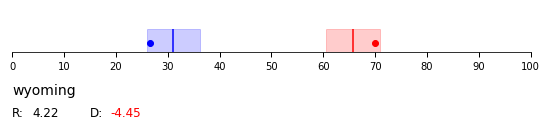

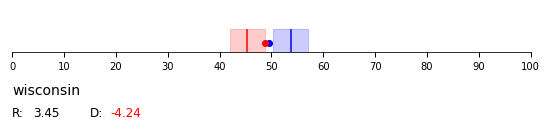

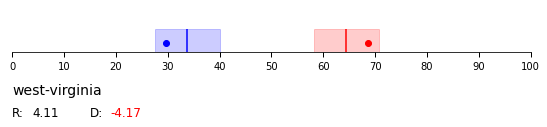

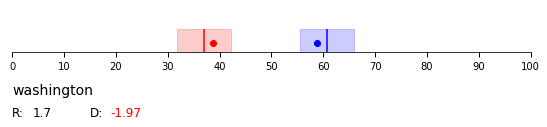

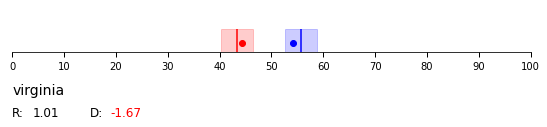

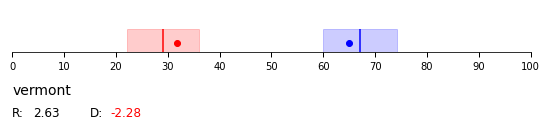

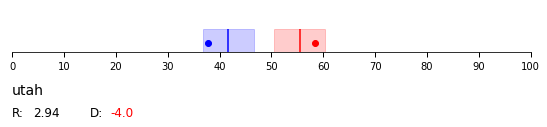

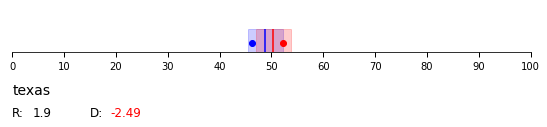

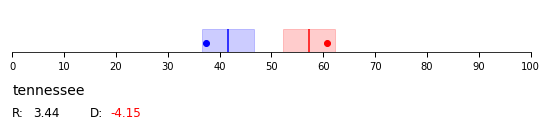

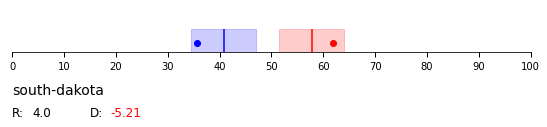

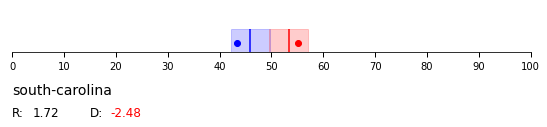

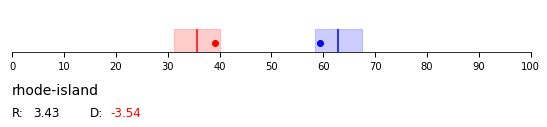

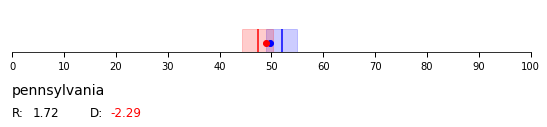

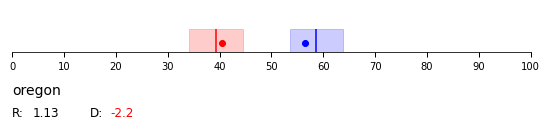

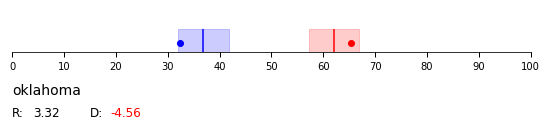

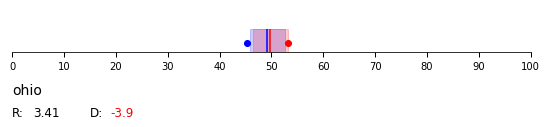

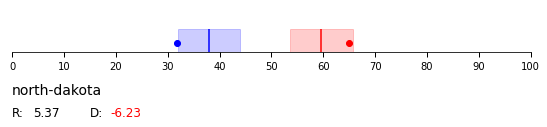

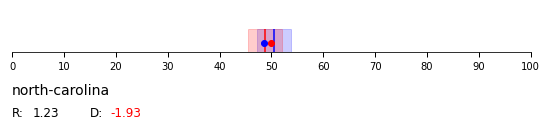

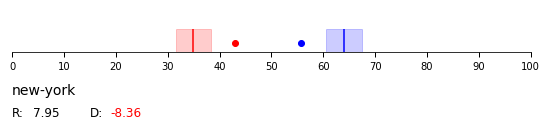

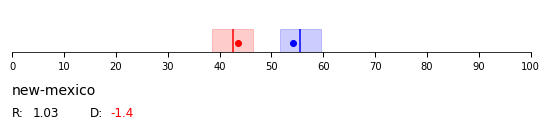

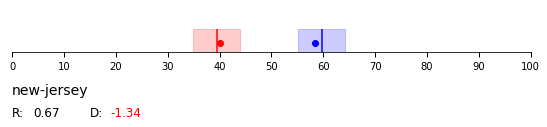

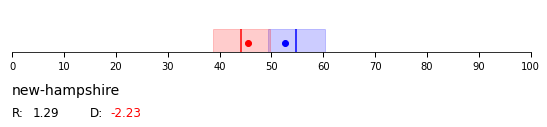

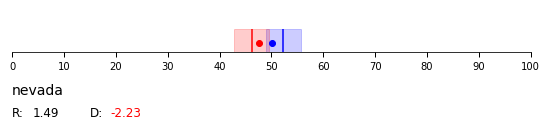

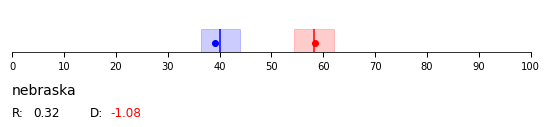

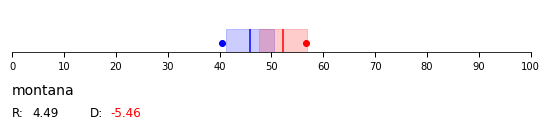

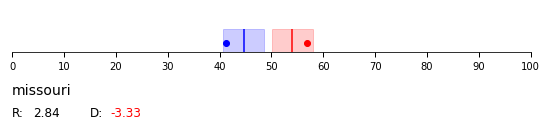

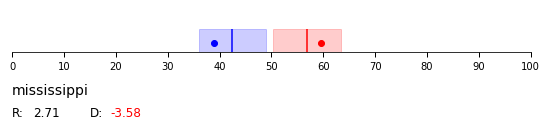

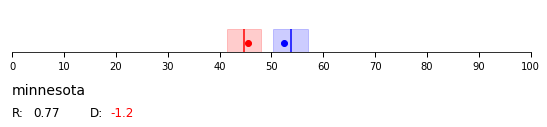

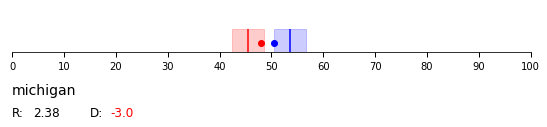

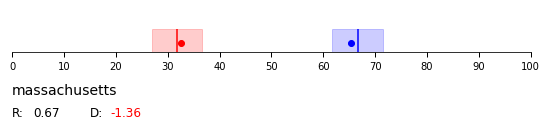

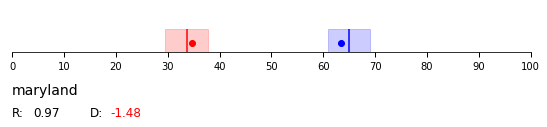

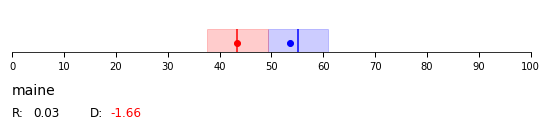

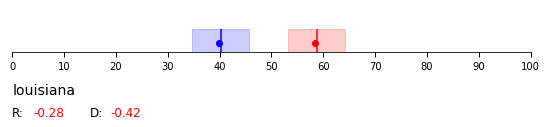

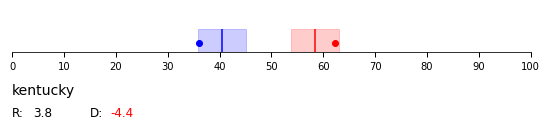

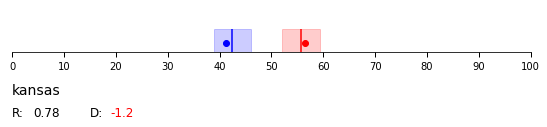

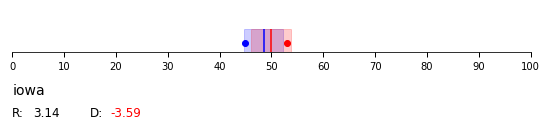

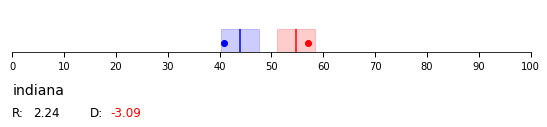

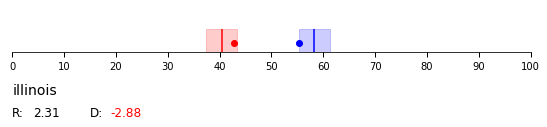

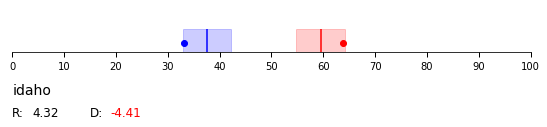

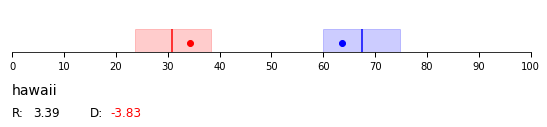

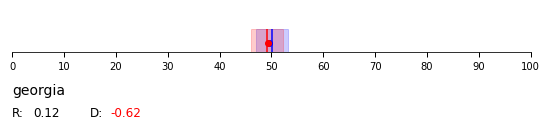

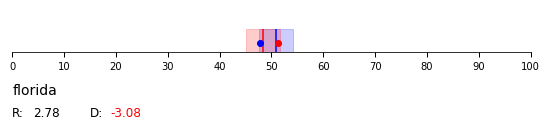

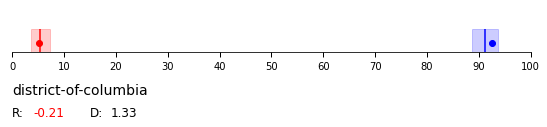

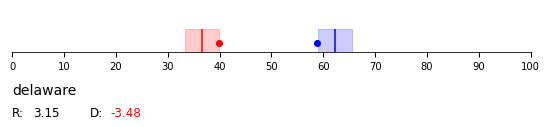

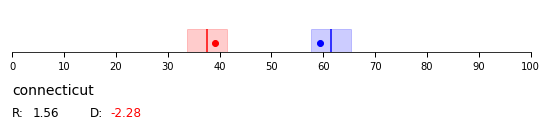

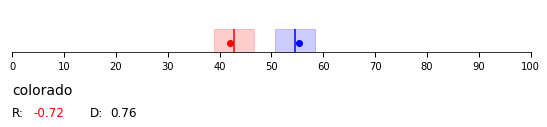

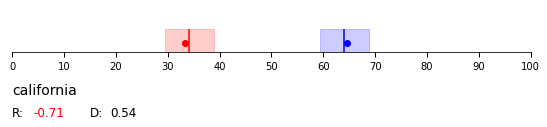

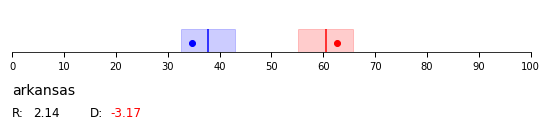

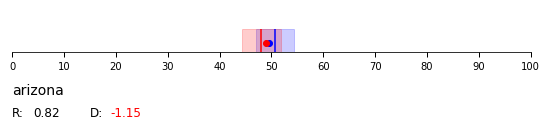

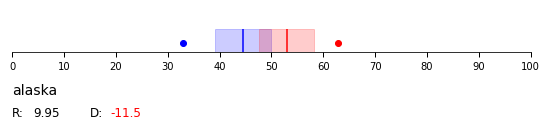

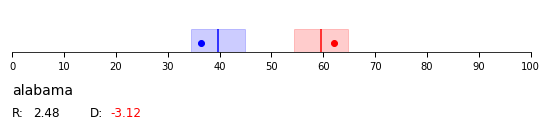

In [254]:
for index, row in master_df.iterrows():
  plt.figure(figsize=(8, 6))
  n = 8
  
  ax = plt.subplot(n, 1, 1)
  setup(ax)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

  # Plotting Challenger Blue
  ax.plot(row['d_real'], 0.2, 'bo', color = 'blue')
  ax.vlines(x = row['voteshare_chal'], ymin = 0, ymax = 0.5, color = 'blue')
  ax.axvspan(xmin = row['voteshare_chal_lo'], xmax = row['voteshare_chal_hi'], ymax = 0.5, alpha=0.2, color='blue')

  # Plotting Incumbent Red
  ax.plot(row['r_real'], 0.2, 'bo', color = 'red')
  ax.vlines(x = row['voteshare_inc'], ymin = 0, ymax = 0.5, color = 'red')
  ax.axvspan(xmin = row['voteshare_inc_lo'], xmax = row['voteshare_inc_hi'], ymax = 0.5, alpha=0.2, color='red')

  ax.text(0, -0.9, row['state'], fontsize=14,transform=ax.transAxes)
  ax.text(0, -1.4, 'R:', fontsize=12)
  ax.text(4, -1.4, row['inc_dif'], fontsize=12, color = color(row['inc_dif']))
  ax.text(15, -1.4, 'D:', fontsize=12)
  ax.text(19, -1.4, row['chal_dif'], fontsize=12, color = color(row['chal_dif']))
  
  # Push the top of the top axes outside the figure because we only show the
  # bottom spine.
  plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=1.05)
  plt.show()
